In [1]:
!pip install datasets evaluate
!pip install setfit transformers==4.39.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [2]:
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset
from datasets import Dataset
import pandas as pd

In [ ]:
from sklearn.metrics import f1_score

In [3]:
train_data = pd.read_csv("/content/train.csv")

In [4]:
train_data.drop(columns=['essay_id'], inplace=True)
train_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...
17302,"the story "" The Challenge of Exploing Venus "" ...",2
17303,Technology has changed a lot of ways that we l...,4
17304,If you don't like sitting around all day than ...,2
17305,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [5]:
train_data.rename(columns={'full_text': 'text', 'score': 'label'}, inplace=True)
train_data['label'] = train_data.label.astype('str')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
train_data['text'][0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Many people have car where they live. The thing they don\'t know is that when you use a car alot of thing can happen\xa0like you can get in accidet or\xa0the smoke that the car has is bad to breath\xa0on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban\'s families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden\xa0on the outskirts of freiburd that near the French and Swiss borders. You probaly won\'t see a car in Vauban\'s streets because they are completely "car free" but\xa0If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states an

Тексты слишком длинные:

In [7]:
train_data['text'].apply(len).mean()

2071.6172646905875

Возьмем первые пять предложений из каждого текста:

In [8]:
train_data['text'] = train_data['text'].str.replace('\xa0', ' ').str.split('.').str[0:5]

In [9]:
train_data = train_data.assign(text=train_data["text"].apply(lambda l: ". ".join(l)))

Сократим, таким образом, количество данных

In [10]:
train_data['text'].apply(len).mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


571.3363378979603

Возьмем произвольную выборку

In [11]:
train = train_data[:121]
test = train_data[121:155]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

Дотренируем SetFit

In [13]:
model = SetFitModel.from_pretrained("BAAI/bge-small-en-v1.5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [14]:
model.labels = ["1", "2", "3", "4", "5", "6"]

In [15]:
args = TrainingArguments(
    batch_size=32,
    num_epochs=10
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
)

Map:   0%|          | 0/121 [00:00<?, ? examples/s]

In [16]:
trainer.train()

***** Running training *****
  Num unique pairs = 10644
  Batch size = 32
  Num epochs = 10
  Total optimization steps = 3330


Step,Training Loss


In [17]:
trainer.evaluate(test)

***** Running evaluation *****


{'accuracy': 0.4411764705882353}

In [ ]:
f1_score(test['label'], model.predict(test['text']), average='weighted')

0.3844444444444444

Наш датасет несбалансированный:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


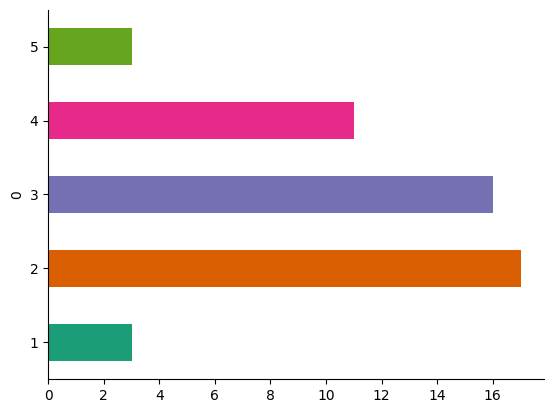

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
pd.DataFrame(test['label']).groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Сделаем сбалансированный датасет:

In [ ]:
train_data_balanced = pd.concat([train_data[train_data['label'] == '1'][0:21],
                                 train_data[train_data['label'] == '2'][0:21],
                                 train_data[train_data['label'] == '3'][0:21],
                                 train_data[train_data['label'] == '4'][0:21],
                                 train_data[train_data['label'] == '5'][0:21],
                                 train_data[train_data['label'] == '6'][0:21]])

In [ ]:
train_data_balanced = train_data_balanced.sample(frac = 1)

In [ ]:
train_data_balanced['text'] = train_data_balanced['text'].str.replace('\xa0', ' ').str.split('.').str[0:5]
train_data_balanced = train_data_balanced.assign(text=train_data_balanced["text"].apply(lambda l: ". ".join(l)))

In [ ]:
train_data_balanced

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,label
48,Just Straight FACS\n\nAnybody can read a room....,4
253,the advantages of limiting car usage are very ...,1
28,Using technology to read emotional expressions...,4
664,The Electoral College is a system which was es...,6
554,Is it possible to be too passionte about somet...,5
...,...,...
155,"In the article ""Making Mona Lisa Smile,"" the a...",1
828,Studying Venus is a worthy pursuit. Studying ...,6
55,It would be dangerous to go to venus it would ...,2
4,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
train = train_data_balanced[:101]
test = train_data_balanced[101:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(train), len(test)

(101, 25)

In [ ]:
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

In [ ]:
args = TrainingArguments(
    batch_size=32,
    num_epochs=10,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
)

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Метрики упали:

In [ ]:
trainer.train()

***** Running training *****
  Num unique pairs = 8500
  Batch size = 32
  Num epochs = 10
  Total optimization steps = 2660


Step,Training Loss


In [ ]:
trainer.evaluate(test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
***** Running evaluation *****


{'accuracy': 0.16}

In [ ]:
f1_score(test['label'], model.predict(test['text']), average='weighted')

0.1822222222222222

Попытка оценивать эссе как среднее отдельных предложений показывает, что у нас в данных сильный перекос в сторону лейблов 2-3, поэтому более высокие оценки не получаются

In [ ]:
final_marksheet = []
for essay in train_data['text'][0:100]:
    sentence_total = 0
    for j in essay.split('.'):
        sentence_total += int(model.predict(j))
    final_marksheet.append(str(round(sentence_total/len(essay.split(".")))))
final_marksheet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '2',
 '1',
 '1',
 '3',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '3',
 '2',
 '2',
 '3',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '3',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '2',
 '2',
 '3',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '3',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '3',
 '2',
 '2',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2']

In [ ]:
len(final_marksheet)

100

In [ ]:
f1_score(train_data['label'][0:100], final_marksheet, average='weighted')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.13841601870383816